In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
DATA_DIR = "/kaggle/input/lungcancer4types-imagedataset/Data"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")


In [ ]:
def print_class_distribution(folder, split_name):
    dataset = datasets.ImageFolder(folder)
    counts = Counter(dataset.targets)
    print(f"\n{split_name} distribution:")
    for idx, cls in enumerate(dataset.classes):
        print(f"{cls}: {counts[idx]}")

print_class_distribution(TRAIN_DIR, "Train")
print_class_distribution(VAL_DIR, "Validation")
print_class_distribution(TEST_DIR, "Test")



Train distribution:
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115
normal: 148
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155

Validation distribution:
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 23
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 21
normal: 13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 15

Test distribution:
adenocarcinoma: 120
large.cell.carcinoma: 51
normal: 54
squamous.cell.carcinoma: 90


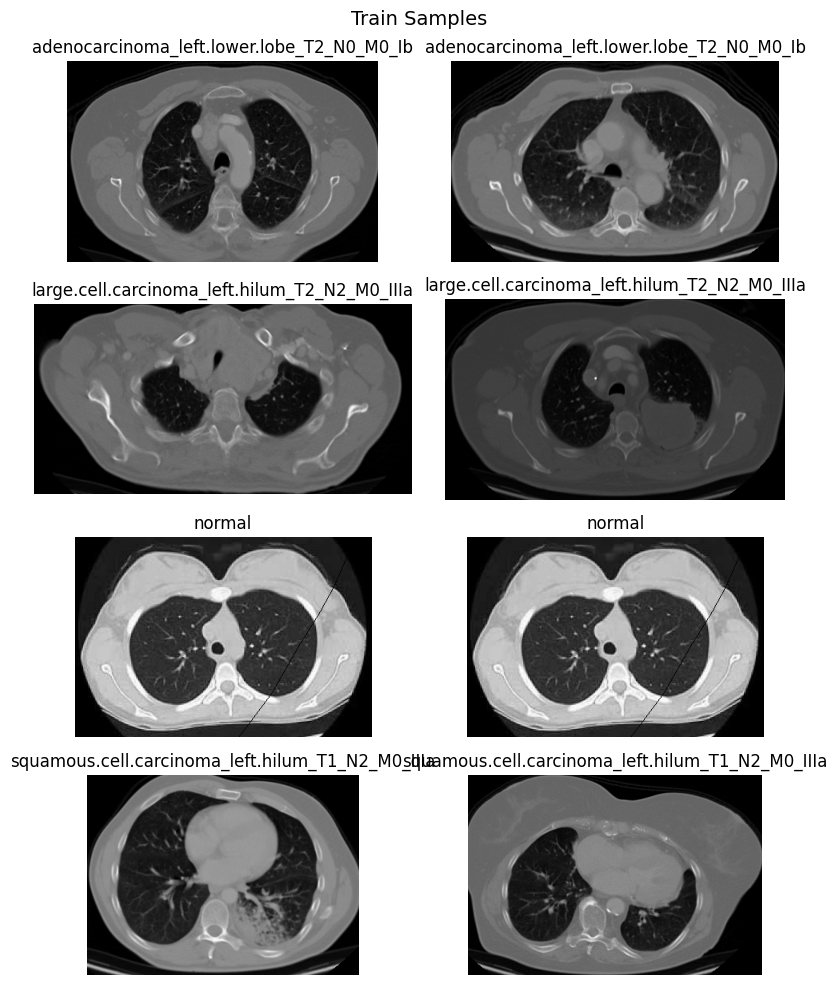

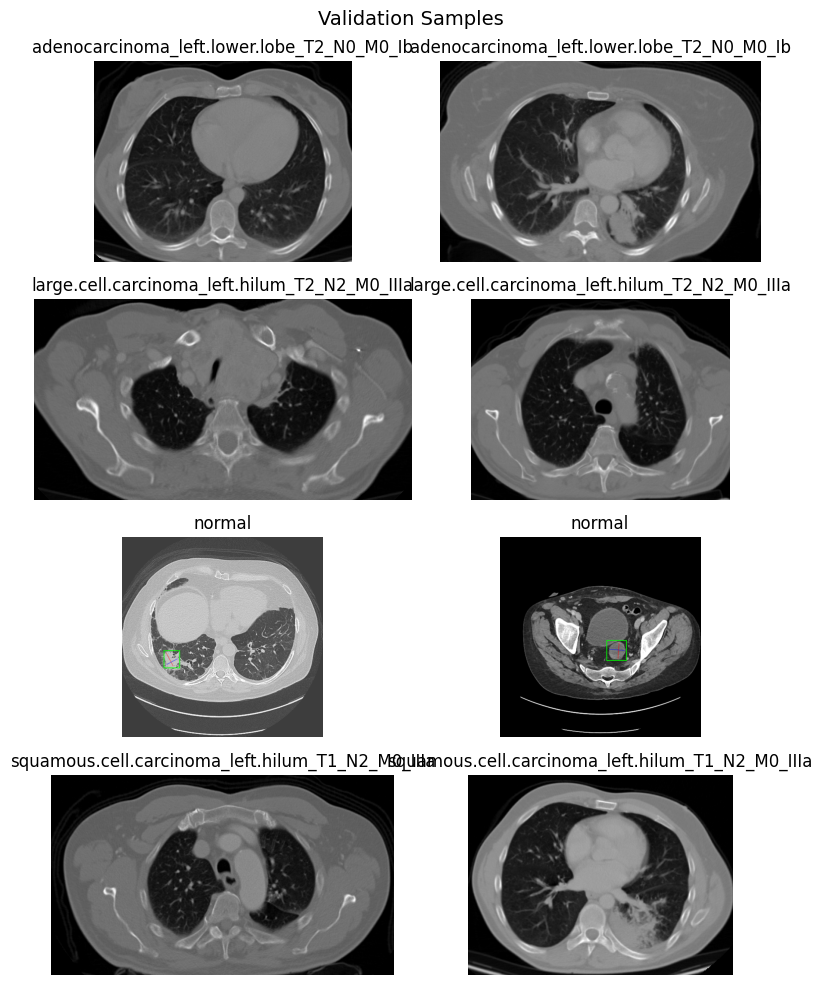

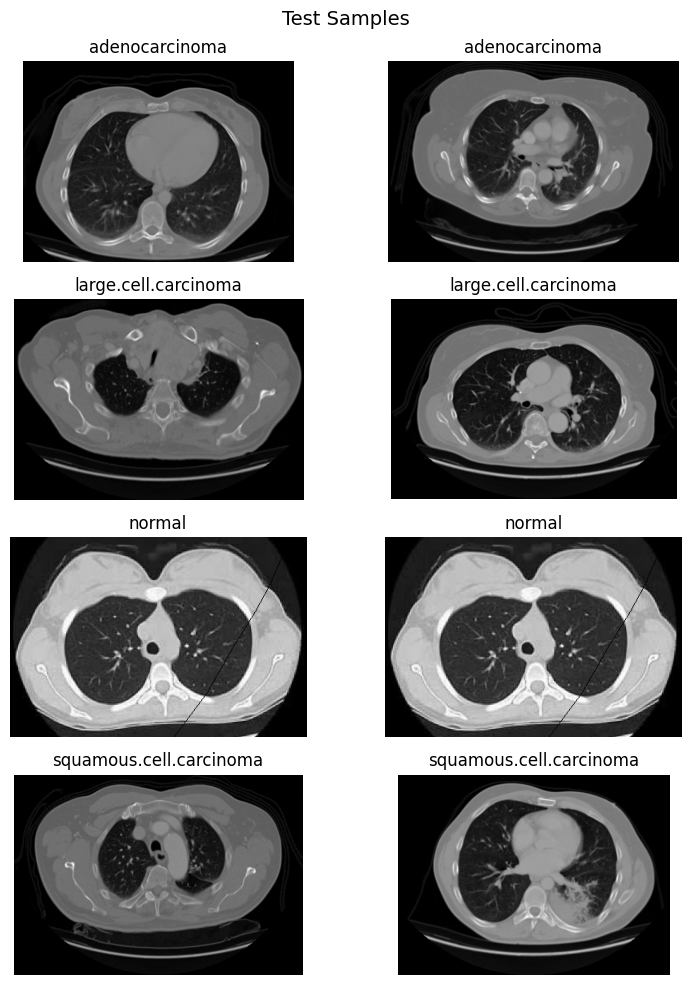

In [ ]:
def show_images(folder, title, n_per_class=2):
    dataset = datasets.ImageFolder(folder)
    class_indices = {i: [] for i in range(len(dataset.classes))}

    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < n_per_class:
            class_indices[label].append(idx)

    images = []
    labels = []

    for label, idxs in class_indices.items():
        for idx in idxs:
            img, lbl = dataset[idx]
            images.append(img)
            labels.append(dataset.classes[lbl])

    fig, axes = plt.subplots(len(dataset.classes), n_per_class, figsize=(8, 10))
    fig.suptitle(title, fontsize=14)

    for i in range(len(images)):
        ax = axes[i // n_per_class, i % n_per_class]
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_images(TRAIN_DIR, "Train Samples")
show_images(VAL_DIR, "Validation Samples")
show_images(TEST_DIR, "Test Samples")


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

NUM_CLASSES = len(train_ds.classes)
print("Classes:", train_ds.classes)


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [ ]:
from torchvision import models
import torch.nn as nn

model = models.efficientnet_b0(weights="IMAGENET1K_V1")

# Replace classifier
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    NUM_CLASSES
)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 197MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4
)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float("inf")
        self.stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    matthews_corrcoef
)

from tqdm import tqdm


In [ ]:
def compute_metrics(y_true, y_pred, y_prob, num_classes):
    metrics = {}

    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["f1"] = f1_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["mcc"] = matthews_corrcoef(y_true, y_pred)

    # Sensitivity = Recall
    metrics["sensitivity"] = metrics["recall"]

    # Specificity (macro)
    cm = confusion_matrix(y_true, y_pred)
    specificity = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp + 1e-8))
    metrics["specificity"] = np.mean(specificity)

    # AUC
    try:
        metrics["auc"] = roc_auc_score(
            y_true, y_prob, multi_class="ovr"
        )
    except:
        metrics["auc"] = 0.0

    return metrics


In [ ]:
def run_epoch(model, loader, criterion, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    loop = tqdm(loader)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if train:
            loss.backward()
            optimizer.step()

        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        total_loss += loss.item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())

    avg_loss = total_loss / len(loader)
    return avg_loss, np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [ ]:
EPOCHS = 30
PATIENCE = 5

history = {
    "train": {k: [] for k in ["loss","accuracy","precision","recall","f1","specificity","sensitivity","mcc","auc"]},
    "val":   {k: [] for k in ["loss","accuracy","precision","recall","f1","specificity","sensitivity","mcc","auc"]}
}

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):


    train_loss, y_t, y_p, y_prob = run_epoch(
        model, train_loader, criterion, optimizer, train=True
    )
    train_metrics = compute_metrics(y_t, y_p, y_prob, NUM_CLASSES)
    train_metrics["loss"] = train_loss


    val_loss, y_t, y_p, y_prob = run_epoch(
        model, val_loader, criterion, train=False
    )
    val_metrics = compute_metrics(y_t, y_p, y_prob, NUM_CLASSES)
    val_metrics["loss"] = val_loss


    for k in history["train"]:
        history["train"][k].append(train_metrics[k])
        history["val"][k].append(val_metrics[k])


    print(f"\nTraining Model - Epoch [{epoch+1}/{EPOCHS}]")
    print(
        f"Train Metrics - loss: {train_metrics['loss']:.4f}, "
        f"accuracy: {train_metrics['accuracy']:.4f}, "
        f"precision: {train_metrics['precision']:.4f}, "
        f"recall: {train_metrics['recall']:.4f}, "
        f"f1_score: {train_metrics['f1']:.4f}, "
        f"specificity: {train_metrics['specificity']:.4f}, "
        f"sensitivity: {train_metrics['sensitivity']:.4f}, "
        f"mcc: {train_metrics['mcc']:.4f}, "
        f"auc: {train_metrics['auc']:.4f}"
    )

    print(f"Validating Model - Epoch [{epoch+1}/{EPOCHS}]")
    print(
        f"Val Metrics   - loss: {val_metrics['loss']:.4f}, "
        f"accuracy: {val_metrics['accuracy']:.4f}, "
        f"precision: {val_metrics['precision']:.4f}, "
        f"recall: {val_metrics['recall']:.4f}, "
        f"f1_score: {val_metrics['f1']:.4f}, "
        f"specificity: {val_metrics['specificity']:.4f}, "
        f"sensitivity: {val_metrics['sensitivity']:.4f}, "
        f"mcc: {val_metrics['mcc']:.4f}, "
        f"auc: {val_metrics['auc']:.4f}"
    )

    # -------- EARLY STOPPING --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("\nEarly stopping triggered")
            break


100%|██████████| 5/5 [00:00<00:00, 12.46it/s]



Training Model - Epoch [1/30]
Train Metrics - loss: 1.0748, accuracy: 0.5938, precision: 0.5827, recall: 0.5722, f1_score: 0.5668, specificity: 0.8600, sensitivity: 0.5722, mcc: 0.4491, auc: 0.8134
Validating Model - Epoch [1/30]
Val Metrics   - loss: 0.9843, accuracy: 0.7639, precision: 0.8152, recall: 0.7953, f1_score: 0.7861, specificity: 0.9204, sensitivity: 0.7953, mcc: 0.6951, auc: 0.9037


100%|██████████| 5/5 [00:00<00:00, 12.38it/s]



Training Model - Epoch [2/30]
Train Metrics - loss: 0.6292, accuracy: 0.8336, precision: 0.8639, recall: 0.8183, f1_score: 0.8265, specificity: 0.9417, sensitivity: 0.8183, mcc: 0.7786, auc: 0.9597
Validating Model - Epoch [2/30]
Val Metrics   - loss: 0.5735, accuracy: 0.8056, precision: 0.8346, recall: 0.8280, f1_score: 0.8193, specificity: 0.9338, sensitivity: 0.8280, mcc: 0.7455, auc: 0.9583


100%|██████████| 5/5 [00:00<00:00, 12.83it/s]



Training Model - Epoch [3/30]
Train Metrics - loss: 0.3450, accuracy: 0.9152, precision: 0.9209, recall: 0.9102, f1_score: 0.9136, specificity: 0.9708, sensitivity: 0.9102, mcc: 0.8861, auc: 0.9904
Validating Model - Epoch [3/30]
Val Metrics   - loss: 0.3742, accuracy: 0.8750, precision: 0.8977, recall: 0.8960, f1_score: 0.8833, specificity: 0.9591, sensitivity: 0.8960, mcc: 0.8417, auc: 0.9839


100%|██████████| 5/5 [00:00<00:00, 12.66it/s]



Training Model - Epoch [4/30]
Train Metrics - loss: 0.1941, accuracy: 0.9560, precision: 0.9563, recall: 0.9546, f1_score: 0.9551, specificity: 0.9851, sensitivity: 0.9546, mcc: 0.9408, auc: 0.9977
Validating Model - Epoch [4/30]
Val Metrics   - loss: 0.3250, accuracy: 0.8750, precision: 0.8941, recall: 0.8980, f1_score: 0.8847, specificity: 0.9595, sensitivity: 0.8980, mcc: 0.8411, auc: 0.9857


100%|██████████| 5/5 [00:00<00:00, 12.56it/s]



Training Model - Epoch [5/30]
Train Metrics - loss: 0.1545, accuracy: 0.9739, precision: 0.9742, recall: 0.9744, f1_score: 0.9743, specificity: 0.9911, sensitivity: 0.9744, mcc: 0.9648, auc: 0.9985
Validating Model - Epoch [5/30]
Val Metrics   - loss: 0.2717, accuracy: 0.9167, precision: 0.9286, recall: 0.9233, f1_score: 0.9177, specificity: 0.9737, sensitivity: 0.9233, mcc: 0.8937, auc: 0.9804


100%|██████████| 5/5 [00:00<00:00, 12.27it/s]



Training Model - Epoch [6/30]
Train Metrics - loss: 0.0761, accuracy: 0.9886, precision: 0.9881, recall: 0.9891, f1_score: 0.9886, specificity: 0.9962, sensitivity: 0.9891, mcc: 0.9846, auc: 0.9992
Validating Model - Epoch [6/30]
Val Metrics   - loss: 0.2681, accuracy: 0.9306, precision: 0.9342, recall: 0.9425, f1_score: 0.9342, specificity: 0.9776, sensitivity: 0.9425, mcc: 0.9093, auc: 0.9874


100%|██████████| 5/5 [00:00<00:00, 11.50it/s]



Training Model - Epoch [7/30]
Train Metrics - loss: 0.1103, accuracy: 0.9772, precision: 0.9776, recall: 0.9793, f1_score: 0.9784, specificity: 0.9922, sensitivity: 0.9793, mcc: 0.9693, auc: 0.9980
Validating Model - Epoch [7/30]
Val Metrics   - loss: 0.3962, accuracy: 0.8472, precision: 0.8942, recall: 0.8690, f1_score: 0.8588, specificity: 0.9518, sensitivity: 0.8690, mcc: 0.8154, auc: 0.9750


100%|██████████| 5/5 [00:00<00:00, 12.24it/s]



Training Model - Epoch [8/30]
Train Metrics - loss: 0.0800, accuracy: 0.9869, precision: 0.9873, recall: 0.9866, f1_score: 0.9869, specificity: 0.9955, sensitivity: 0.9866, mcc: 0.9824, auc: 0.9991
Validating Model - Epoch [8/30]
Val Metrics   - loss: 0.2879, accuracy: 0.9167, precision: 0.9286, recall: 0.9327, f1_score: 0.9220, specificity: 0.9737, sensitivity: 0.9327, mcc: 0.8947, auc: 0.9819


100%|██████████| 5/5 [00:00<00:00, 12.19it/s]



Training Model - Epoch [9/30]
Train Metrics - loss: 0.0639, accuracy: 0.9853, precision: 0.9836, recall: 0.9859, f1_score: 0.9847, specificity: 0.9952, sensitivity: 0.9859, mcc: 0.9803, auc: 0.9993
Validating Model - Epoch [9/30]
Val Metrics   - loss: 0.3555, accuracy: 0.8889, precision: 0.9130, recall: 0.9110, f1_score: 0.8974, specificity: 0.9649, sensitivity: 0.9110, mcc: 0.8631, auc: 0.9832


100%|██████████| 5/5 [00:00<00:00, 12.81it/s]



Training Model - Epoch [10/30]
Train Metrics - loss: 0.0611, accuracy: 0.9869, precision: 0.9879, recall: 0.9855, f1_score: 0.9866, specificity: 0.9955, sensitivity: 0.9855, mcc: 0.9824, auc: 0.9988
Validating Model - Epoch [10/30]
Val Metrics   - loss: 0.2887, accuracy: 0.9444, precision: 0.9474, recall: 0.9545, f1_score: 0.9467, specificity: 0.9825, sensitivity: 0.9545, mcc: 0.9281, auc: 0.9787


100%|██████████| 5/5 [00:00<00:00, 11.90it/s]


Training Model - Epoch [11/30]
Train Metrics - loss: 0.0458, accuracy: 0.9869, precision: 0.9876, recall: 0.9857, f1_score: 0.9866, specificity: 0.9955, sensitivity: 0.9857, mcc: 0.9824, auc: 0.9996
Validating Model - Epoch [11/30]
Val Metrics   - loss: 0.4114, accuracy: 0.9028, precision: 0.9137, recall: 0.9218, f1_score: 0.9100, specificity: 0.9683, sensitivity: 0.9218, mcc: 0.8751, auc: 0.9768

Early stopping triggered


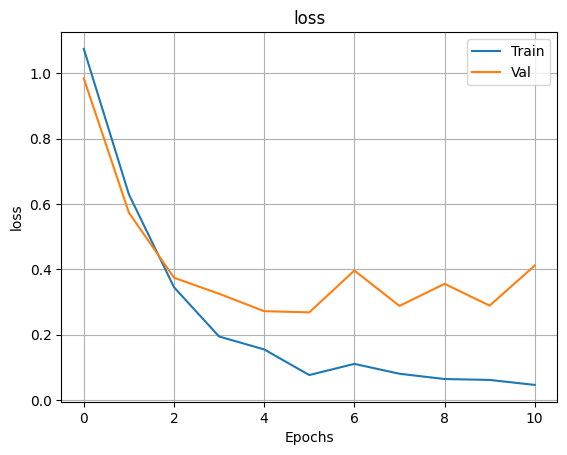

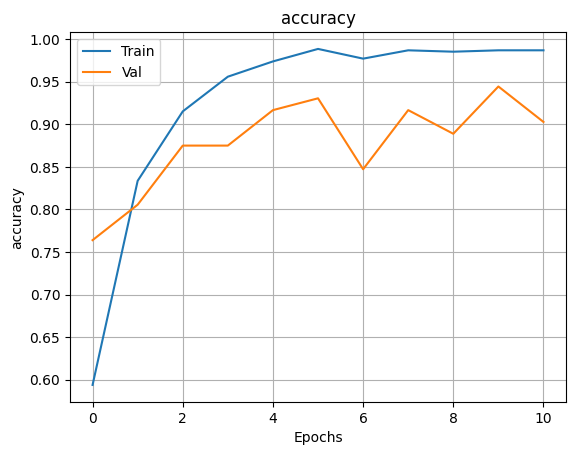

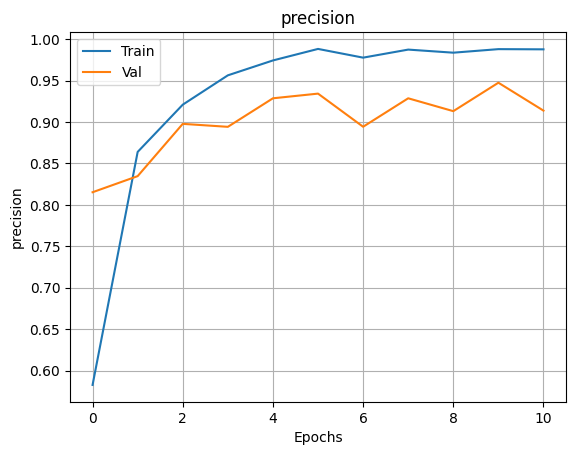

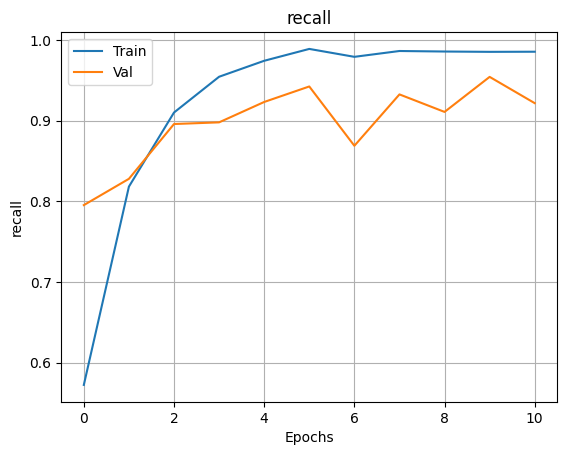

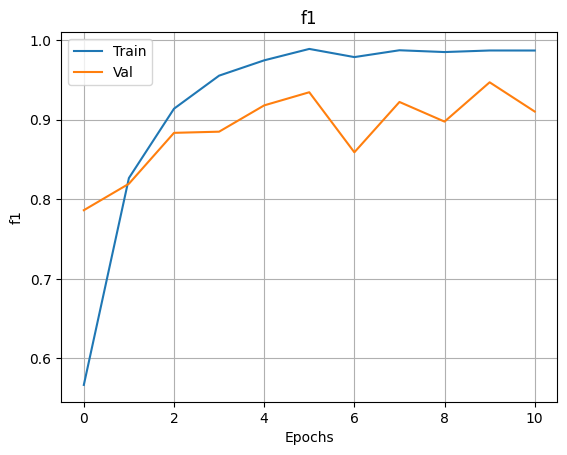

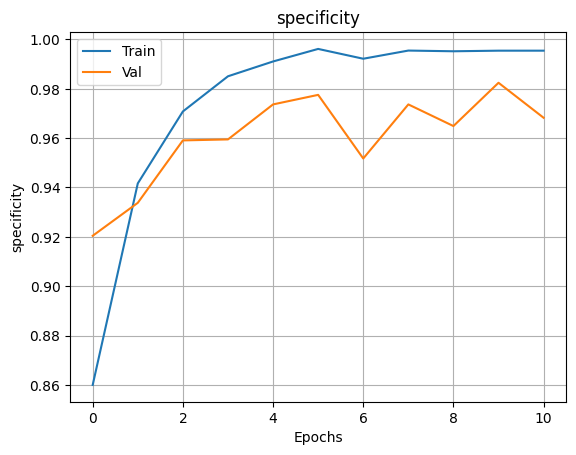

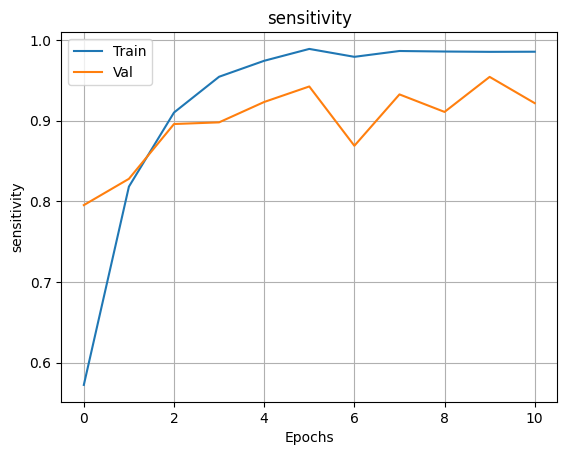

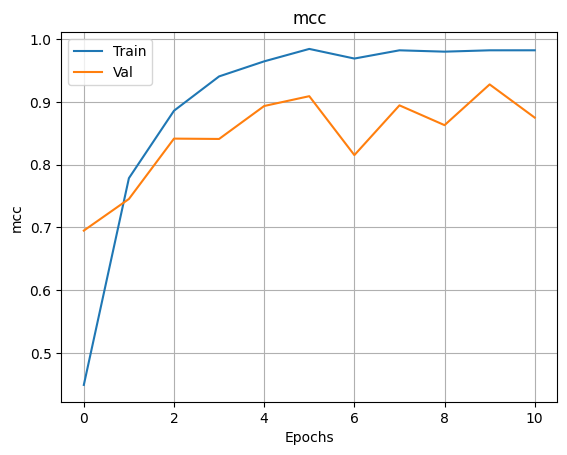

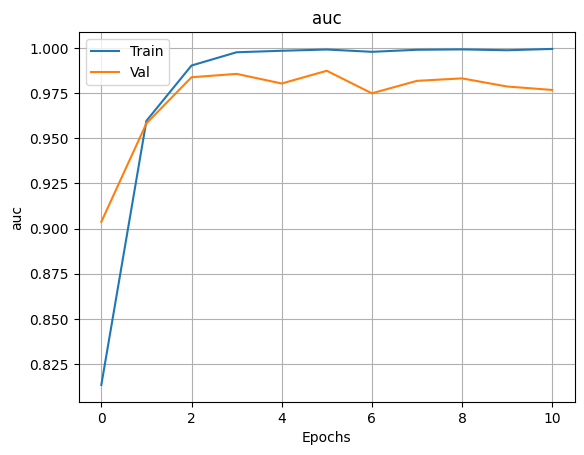

In [ ]:
def plot_metric(metric):
    plt.figure()
    plt.plot(history["train"][metric], label="Train")
    plt.plot(history["val"][metric], label="Val")
    plt.title(metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

metrics_to_plot = [
    "loss","accuracy","precision","recall","f1",
    "specificity","sensitivity","mcc","auc"
]

for m in metrics_to_plot:
    plot_metric(m)


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.classes,digits=4))



Confusion Matrix:
 [[79  7  0 34]
 [ 0 48  0  3]
 [ 1  0 53  0]
 [ 2  3  0 85]]

Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.9634    0.6583    0.7822       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.8276    0.9412    0.8807        51
                                          normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.6967    0.9444    0.8019        90

                                        accuracy                         0.8413       315
                                       macro avg     0.8719    0.8814    0.8639       315
                                    weighted avg     0.8715    0.8413    0.8395       315



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Counts)")
    plt.tight_layout()
    plt.show()


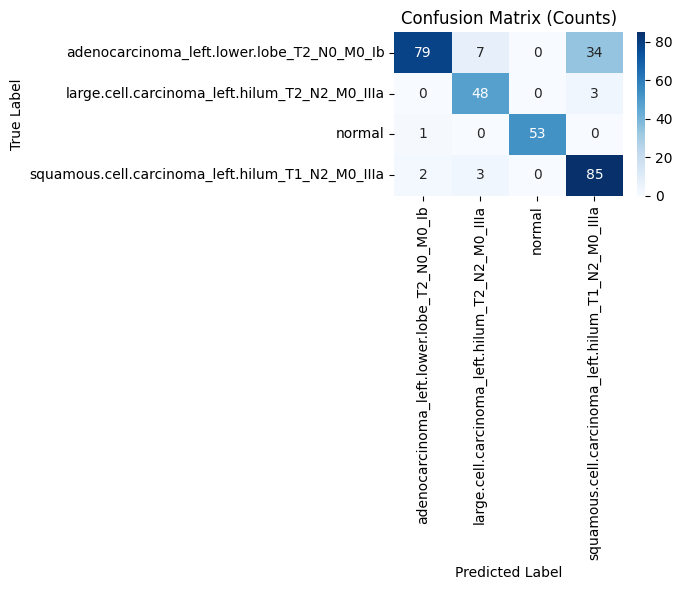

In [ ]:
plot_confusion_matrix(y_true, y_pred, train_ds.classes)


In [ ]:
from sklearn.preprocessing import label_binarize

model.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        y_true.extend(labels.numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

num_classes = y_prob.shape[1]
class_names = train_ds.classes


In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_ovr(y_true, y_prob, class_names):
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    plt.figure(figsize=(8, 6))

    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()


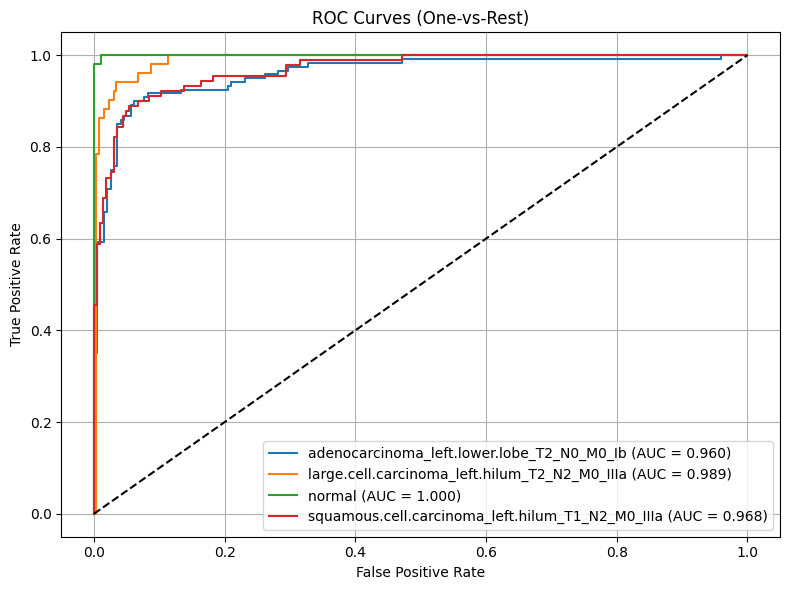

In [ ]:
plot_roc_ovr(y_true, y_prob, train_ds.classes)
